In [49]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime


## Generate data

$f(x)=0.2\sin(2\pi x)+0.8\cos^2(2\pi x)$

In [50]:
coef=2*pi
def my_objective(X):
    Y=0.2*np.sin(coef*X)+0.8*np.cos(coef*X)**2
    return Y

In [51]:
X=np.random.uniform(-0.95,0.95,size=100,requires_grad=False)

In [52]:
Y=my_objective(X)

In [53]:
print(X.shape)
print(Y.shape)

(100,)
(100,)


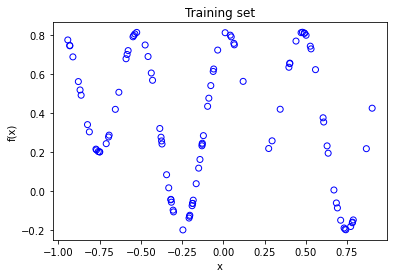

In [54]:
# plot data
plt.scatter(X,Y,facecolors='none', edgecolors='b')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Training set')
# plt.savefig('sin2pix_target.png')
plt.show()

## Set Device

In [55]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

## Define embedding layer

In [56]:
# define my own embedding layer
def myembedding(x,wires):
    qml.RY(coef*x, wires=wires[1])

## Define the Hamiltonian matrix transformation layer

In [57]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

## Define ansatze

In [58]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 0
    qml.RX(theta[0],wires=0)
    qml.RZ(theta[1],wires=0)
    qml.RX(theta[2],wires=0)
    
    # rotations on qubit 1
    qml.RX(theta[3],wires=1)
    qml.RZ(theta[4],wires=1)
    qml.RX(theta[5],wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [59]:
@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))

In [60]:
num_layers=4
num_rotation=6
theta0=np.random.uniform(0,2*pi,size=(num_layers,num_rotation),requires_grad=True)
print(theta0.shape)
print(theta0)

(4, 6)
[[5.2485769  0.94198102 1.83190526 1.70206702 2.84751519 2.83378408]
 [4.35601109 4.86127095 2.14927521 2.88497365 4.89823268 6.13296544]
 [0.78381725 4.90994841 2.07766876 5.91672867 5.23358456 0.98642179]
 [2.71709016 1.97328954 4.34359832 3.73484221 5.67489588 0.8033709 ]]


In [61]:
quantum_net(theta0,0)

tensor([-0.6086202 ,  0.02267195], requires_grad=True)

In [62]:
print(qml.draw(quantum_net)(theta0,0))

0: ──H─────────RX(5.25)──RZ(0.94)──RX(1.83)─╭●──H─────────RX(4.36)──RZ(4.86)──RX(2.15)─╭●──H───────
1: ──RY(0.00)──RX(1.70)──RZ(2.85)──RX(2.83)─╰X──RX(2.88)──RZ(4.90)──RX(6.13)───────────╰X──RX(5.92)

───RX(0.78)──RZ(4.91)──RX(2.08)─╭●──H─────────RX(2.72)──RZ(1.97)──RX(4.34)─╭●──H─┤  <Z>
───RZ(5.23)──RX(0.99)───────────╰X──RX(3.73)──RZ(5.67)──RX(0.80)───────────╰X────┤  <Z>


## Add classical layer

In [63]:
# add the classical layer
def classical_quantum_net(theta,w,x):
    r1=quantum_net(theta,x)[0]
    r2=quantum_net(theta,x)[1]
    return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[3]*r2**2

In [64]:
def square_loss(labels,predictions):
    loss=0
    for l,p in zip(labels,predictions):
        loss=loss+(l-p)**2
    loss=loss/len(labels)
    return loss

In [65]:
def cost(theta,w,features,labels):
    preds=[classical_quantum_net(theta,w,x) for x in features]
    return square_loss(labels,preds)

## Model training
Using the Adam optimizer, we update the weights for 100 steps (this takes some time). More steps will lead to a better fit.

In [66]:
w0=np.zeros(5,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [67]:
start=datetime.datetime.now()
print('time now:', start)

time now: 2022-08-11 15:46:13.227970


## Define the training function

In [68]:
def model_training(epochs,theta,w):
    X=np.random.uniform(-0.95,0.95,size=100,requires_grad=False)
    Y=my_objective(X)
    for e in range(1,epochs+1):
        (theta,w,_,_),_cost=opt.step_and_cost(cost,theta,w,X,Y)
    return theta,w

## Prepare test data

In [69]:
X_test=np.linspace(-0.95,0.95,200)
Y_test=my_objective(X_test)

## Training QNNs mutiple times

In [70]:
list_mean_error=[]
run_times=20
epochs=100
for r in range(run_times):
    theta,w=model_training(epochs,theta0,w0)
    test_pred=[classical_quantum_net(theta,w,x) for x in X_test]
    test_diff=np.abs(Y_test-test_pred)
    mean_error=np.mean(test_diff)
    print(mean_error)
    list_mean_error.append(mean_error)

0.01215154092762619
0.0009129472776100042
0.0009465745461235522
0.0013321513433308624
0.0008455831462261962
0.0018085492802196337
0.0010507255452771222
0.0013947795728697227
0.0012856242966029845
0.0013272705630407893
0.0013326714945361762
0.0015782201467942842
0.001299724678965502
0.0015312788054209334
0.0012251586755069731
0.0012499439747816084
0.00108570576754165
0.0010090864237232173
0.0007417718244729207
0.0014448323232326076


In [71]:
array_mean_error=np.array(list_mean_error)
print(np.var(array_mean_error))

5.730401011813203e-06


In [72]:
start=datetime.datetime.now()
print('time now:', start)

time now: 2022-08-11 18:40:58.937932
